In [1]:
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load necessary libraries
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import ArrowStyle
import math
import numpy as np
import networkx as nx
import os
import pandas as pd
import pickle
import random
from scipy.optimize import nnls
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import scipy
import scipy.cluster.hierarchy as sch
from scipy.stats import mannwhitneyu, normaltest
from scipy.spatial.distance import jensenshannon
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import affinity_propagation
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
import statsmodels.api as sm
from statannotations.Annotator import Annotator
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from itertools import product
import string

/home/atheistpoet/anaconda3/envs/scvi_cell_cycle_env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/atheistpoet/anaconda3/envs/scvi_cell_cycle_env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/atheistpoet/anaconda3/envs/s

In [35]:
# load required custom functions from utils
from utils import create_abundance_header_new, compute_cons_abun_prod, \
    hierarchical_cluster_metabs, \
    get_metabs_clusters, avg_consumption_df, fit_ss_Ri, match_lhs_rhs_fit, \
    blindly_pred_abun_growth, fit_dynamic_Ri, compute_growth_ratio_iterate_blind_seq, \
    blindly_pred_abun_growth_seq, blindly_pred_abun_loggrowth, remove_passages, \
    fit_dynamic_Ri_with_sim_inoc, \
    fit_dynamic_Ri_with_sim_inoc_bal, compute_Ri_dynamic_goodness_of_fit, \
    plot_panel_pred_vs_obs_abundance_blind, compute_growth_ratio_iterate_blind, \
    blindly_pred_abun_growth_without_inoc, load_data_manuscript, metabs_to_remove_knockdown_species, \
    get_RMSE_Balone_func, get_B_alone_func, iterate_growth_ratio, geometric_avg, \
    get_RMSE_against_uniform_sd, random_competition_index, random_crossfeeding_index, \
    get_competition, \
    get_competition_weighted, get_competition_weighted_2, \
    get_crossfeeding, random_competition_subset, compute_species_metab_matrix_for_nnls

# load manuscript data

In [5]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data_manuscript'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, \
                                         f'greedy_algorithm_results.pickle'))


with open(file_save, "rb") as file_:
     Ri_adjust_obj = pickle.load(file_)
solution_list = Ri_adjust_obj['solution_list']
error_traj_list = Ri_adjust_obj['error_traj_list']

In [453]:
# read all data required to reproduce the figures in the manuscript
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data_manuscript'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, \
                                         f'data_to_reproduce_manuscript_figures.pickle'))
with open(file_save, "rb") as file_:
        data_obj = pickle.load(file_)
df_speciesMetab = data_obj['df_speciesMetab']
df_speciesMetab_prod = data_obj['df_speciesMetab_prod']
df_speciesAbun = data_obj['df_speciesAbun']
df_speciesAbun_inoc = data_obj['df_speciesAbun_inoc']
df_speciesAbun_ratio = data_obj['df_speciesAbun_ratio']
df_speciesAbun_prev = data_obj['df_speciesAbun_prev']
df_speciesAbun_next = data_obj['df_speciesAbun_next']
metab_names = data_obj['metab_names']
species_names = data_obj['species_names']
species_names_abbr = data_obj['species_names_abbr']
Ri_dynamic_obj = data_obj['Ri_dynamic_obj']
df_metabs_clusters = data_obj['df_metabs_clusters']
df_speciesMetab_cluster = data_obj['df_speciesMetab_cluster']
df_speciesMetab_prod_cluster = data_obj['df_speciesMetab_prod_cluster']

In [7]:
# set fixed params for all analysis
id_species_keep = np.arange(len(species_names))
num_species = len(species_names)
num_metabs = len(metab_names)
num_passages = 6
num_bioRep = 3
df_speciesAbun_mdl = df_speciesAbun.copy()
df_speciesAbun_prev_mdl = df_speciesAbun_prev.copy()
df_speciesAbun_next_mdl = df_speciesAbun_next.copy()
df_speciesAbun_ratio_mdl = df_speciesAbun_ratio.copy()

In [107]:
df_speciesAbun

,p1_r0,p2_r0,p3_r0,p4_r0,p5_r0,p6_r0,p1_r1,p2_r1,p3_r1,p4_r1,p5_r1,p6_r1,p1_r2,p2_r2,p3_r2,p4_r2,p5_r2,p6_r2
Acidaminococcus fermentans DSMZ 20731,3.180398e-02,1.232587e-04,6.704587e-06,1.964384e-05,2.923860e-04,6.674918e-04,3.751642e-02,1.509550e-04,2.801973e-04,3.247537e-03,2.649064e-02,6.867454e-03,4.710307e-02,6.802839e-04,2.546092e-04,1.037398e-04,1.317724e-04,2.793396e-04
Acidaminococcus intestini D21 BEI HM-81,2.174619e-01,2.143392e-01,3.034948e-01,2.783072e-01,2.449287e-01,2.852345e-01,2.173035e-01,1.983694e-01,2.674704e-01,3.043407e-01,2.476548e-01,2.650648e-01,1.584982e-01,2.045056e-01,2.981957e-01,3.043595e-01,3.054243e-01,2.736223e-01
Anaerostipes caccae DSMZ 14662,3.053745e-02,7.893345e-02,4.178763e-02,1.553076e-02,2.513826e-02,7.685045e-03,3.393580e-02,9.603154e-03,3.142386e-02,1.700029e-02,2.282783e-02,6.528065e-03,3.420288e-02,4.933659e-03,1.727806e-02,7.776625e-03,6.220632e-02,8.449614e-03
Anaerotruncus colihominis DSMZ 17241,7.641646e-05,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,9.158013e-05,1.277543e-06,2.257240e-07,1.000000e-08,8.028099e-08,1.000000e-08,7.865395e-05,7.965272e-07,1.000000e-08,1.000000e-08,1.000000e-08,1.575602e-07
Bacteroides caccae ATCC 43185,7.633257e-02,2.583468e-05,3.153010e-06,3.753517e-06,2.028774e-06,2.470496e-06,7.271956e-02,4.145522e-05,4.789548e-06,6.430825e-06,1.331149e-06,1.814534e-06,6.615639e-02,1.118852e-04,1.638908e-04,2.938171e-06,5.076057e-06,2.018581e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ruminococcus gnavus ATCC 29149,2.173690e-03,2.872359e-02,6.526354e-03,3.918121e-03,4.421267e-03,5.849030e-03,2.753382e-03,1.592495e-02,6.138713e-03,5.560732e-03,6.711834e-03,1.701515e-03,3.988645e-03,9.989043e-03,3.268566e-03,2.781552e-03,6.712029e-03,5.861230e-03
Ruminococcus torques ATCC 27756,2.727114e-04,9.021892e-05,2.965475e-06,4.094933e-06,1.882528e-05,1.090201e-05,2.477832e-04,3.475236e-05,5.534024e-05,1.792223e-05,6.581487e-05,4.976816e-05,2.444333e-04,3.758673e-05,4.198384e-05,3.080377e-05,1.010013e-05,8.941000e-05
Slackia exigua ATCC 700122,1.776472e-03,2.920661e-03,1.421295e-03,2.227100e-03,1.239252e-03,9.714653e-04,1.821668e-03,2.737841e-03,1.899006e-03,7.986064e-04,3.016710e-04,3.447447e-04,2.231052e-03,2.531160e-03,3.458196e-03,4.025108e-03,1.840863e-03,1.107381e-03
Streptococcus thermophilus LMD-9 ATCC 19258,3.879986e-07,1.000000e-08,8.662693e-08,1.000000e-08,1.000000e-08,1.000000e-08,6.177283e-07,1.000000e-08,1.000000e-08,1.459906e-07,1.000000e-08,1.000000e-08,8.277804e-07,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08


PearsonRResult(statistic=0.7235131252393011, pvalue=2.107155259168189e-11)
PearsonRResult(statistic=0.41404244652615974, pvalue=0.000742707282010386)
1.956294563385317


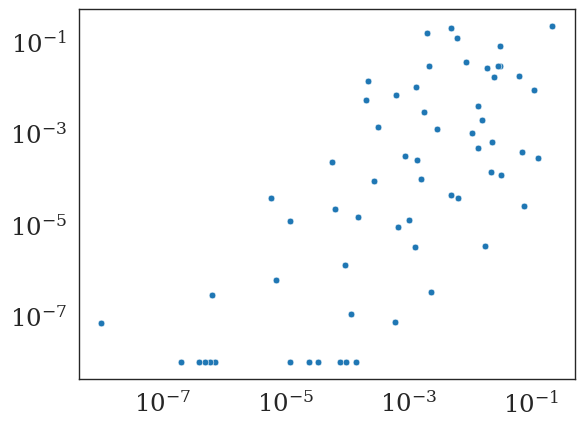

In [376]:
import scipy.stats

rep_ = 0
x = df_speciesAbun.iloc[:, 0 + rep_].values.copy()
y = df_speciesAbun.iloc[:, 1 + rep_].values.copy()
plt_ = sns.scatterplot(x=x, y=y)
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)
print(scipy.stats.pearsonr(np.log10(x), np.log10(y)))
print(scipy.stats.pearsonr(x, y))
abs_mean_error = np.sqrt(np.mean(np.power(np.log10(y) - np.log10(x), 2)))
print(abs_mean_error)

PearsonRResult(statistic=0.9286102627002074, pvalue=5.948612312182756e-28)
PearsonRResult(statistic=0.6746003443254973, pvalue=1.3444813182903926e-09)
0.977707854965936


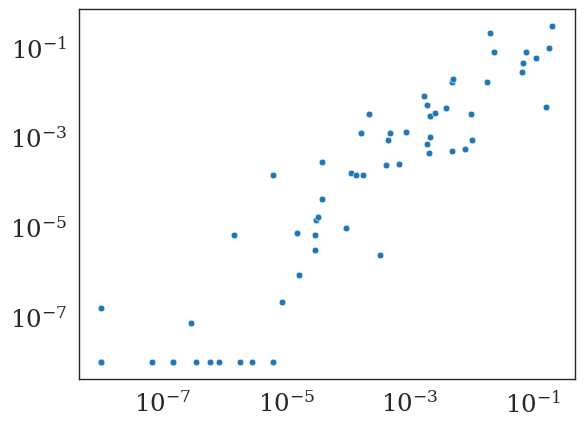

In [371]:
import scipy.stats

rep_ = 12
x = df_speciesAbun.iloc[:, 1 + rep_].values.copy()
y = df_speciesAbun.iloc[:, 2 + rep_].values.copy()
plt_ = sns.scatterplot(x=x, y=y)
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)
print(scipy.stats.pearsonr(np.log10(x), np.log10(y)))
print(scipy.stats.pearsonr(x, y))
abs_mean_error = np.sqrt(np.mean(np.power(np.log10(y) - np.log10(x), 2)))
print(abs_mean_error)

In [435]:
# shuffle consumption matrix
def shuffle_matrix_preserve_row_sum(matrix):
    shuffled_matrix = np.zeros_like(matrix)
    
    for i, row in enumerate(matrix):
        np.random.shuffle(row)
        shuffled_matrix[i] = row
        
    return shuffled_matrix

def shuffle_matrix_preserve_col_sum(matrix):
    shuffled_matrix = np.zeros_like(matrix)
    
    for i, col in enumerate(matrix.T):
        np.random.shuffle(col)
        shuffled_matrix[:, i] = col
        
    return shuffled_matrix

In [436]:
seed = 982
np.random.seed(seed)
speciesMetab_matrix = df_speciesMetab.values.copy()
speciesMetab_matrix = shuffle_matrix_preserve_row_sum(speciesMetab_matrix)
df_speciesMetab_row_shuffled = \
    pd.DataFrame(speciesMetab_matrix, columns=metab_names, index=species_names)

In [43]:
shuffled_df = df_speciesMetab.copy()
# shuffled_df = shuffled_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_df = shuffled_df.apply(lambda x: x.sample(frac=1).reset_index(drop=True))
df_speciesMetab_row_shuffled = shuffled_df.copy()

In [44]:
shuffled_df

,GALACTOSAMINE,N-METHYL-ASPARTIC ACID_0,2-AMINO-2-METHYLPROPANOIC ACID,NICOTINIC ACID,OLEIC ACID,MANNOSE 6-PHOSPHATE,VALINE_0,SUCROSE_0,THREONINE_0,BETA-ALANINE_0,...,TRANEXAMIC ACID,TRIGONELLINE,TRYPTAMINE,TRYPTOPHAN,TYRAMINE,TYROSINE,URACIL,URIDINE,VALINE_1,XANTHOSINE
0,0.00000,0.000000,0.217158,0.000000,0.0,0.786516,0.000000,0.004468,0.168659,0.698327,...,0.000000,0.000000,0.000000,0.155358,0.151394,0.000000,0.989210,0.004037,0.000000,0.0
1,0.00000,0.000000,0.000000,0.868974,0.0,0.175925,0.091633,0.000000,0.348466,0.513204,...,0.000000,0.043567,0.000000,0.025765,0.013378,0.000000,0.059409,0.108103,0.000000,0.0
2,0.00000,0.308609,0.000000,0.000000,0.0,0.105813,0.000000,0.000000,0.136175,0.366474,...,0.173798,0.000000,0.000000,0.076617,0.000000,0.295192,0.000000,0.000000,0.000000,0.0
3,0.00000,0.000000,0.417445,0.000000,0.0,0.375303,0.102268,0.000000,0.063359,0.731824,...,0.000000,0.000000,0.379454,0.000000,0.051803,0.000000,0.000000,0.985360,0.000000,0.0
4,0.00000,0.119998,0.000000,0.872839,0.0,0.566370,0.007696,0.000000,0.000000,0.722238,...,0.000000,0.000000,0.000000,0.000000,0.110052,0.000000,0.607672,0.000000,0.065435,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.00000,0.000000,0.000000,0.179604,0.0,0.627831,0.136014,0.000000,0.000000,0.427961,...,0.000000,0.044833,0.000000,0.762009,0.000000,0.313218,0.767428,0.070147,0.254068,0.0
59,0.00000,0.000000,0.000000,0.000000,0.0,0.563057,0.000000,0.000000,0.165624,0.000000,...,0.000000,0.000000,0.108907,0.000000,0.099211,0.027537,0.000000,0.787062,0.000000,0.0
60,0.00000,0.000000,0.000000,0.000000,0.0,0.021966,0.000000,0.000000,0.000000,0.077823,...,0.404518,0.055577,0.000000,0.091814,0.000000,0.260463,0.999989,0.846562,0.161154,0.0
61,0.00000,0.000000,0.000000,0.167670,0.0,0.479983,0.000000,0.000000,0.000000,0.150745,...,0.000000,0.000000,0.000000,0.053831,0.115869,0.047239,0.000000,0.000000,0.000000,0.0


In [45]:
shuffled_df.values - df_speciesMetab.values

array([[ 0.        , -0.99295876,  0.21715828, ..., -0.06611006,
         0.        ,  0.        ],
       [ 0.        , -0.98792863,  0.        , ...,  0.10810319,
         0.        ,  0.        ],
       [ 0.        ,  0.30860907,  0.        , ...,  0.        ,
        -0.28522299,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.08596838,
         0.16115433,  0.        ],
       [ 0.        , -0.16289849, -0.21715828, ..., -0.79904127,
        -0.06557385,  0.        ],
       [ 0.20805995,  0.07137722,  0.        , ...,  0.17198799,
         0.        ,  0.        ]])

In [454]:
# If you want to cluster the metabolites on your own uncomment the following and run
nclusts = 10
df_metabs_clusters, df_speciesMetab_new, df_speciesMetab_prod_new = \
    get_metabs_clusters(df_speciesMetab.copy(), df_speciesMetab_prod.copy(), \
                        bin_thresh=0.3, species_num_thresh=5, \
                        n_clusters_hclust=nclusts, distance_metric="euclidean", \
                        method_cluster="ward", normalize_=False)
df_speciesMetab_cluster, df_speciesMetab_prod_cluster = \
    avg_consumption_df(df_speciesMetab_new, df_speciesMetab_prod_new, df_metabs_clusters, \
                       metab_cluster_mean_func="geometric")

# ensure matebolite clusters are numbered starting from 1 and not 0
metab_cluster_names = []
for m_ in range(df_speciesMetab_cluster.shape[1]):
    metab_cluster_names.append(f'{m_ + 1}')

# speciesMetab_matrix = df_speciesMetab_cluster.values.copy()
# speciesMetab_matrix = shuffle_matrix_preserve_row_sum(speciesMetab_matrix)
# df_speciesMetab_cluster = \
#     pd.DataFrame(speciesMetab_matrix, columns=metab_cluster_names, index=species_names)
df_speciesMetab_cluster_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_cluster.columns = metab_cluster_names

In [455]:
metab_cluster_names

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98']

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

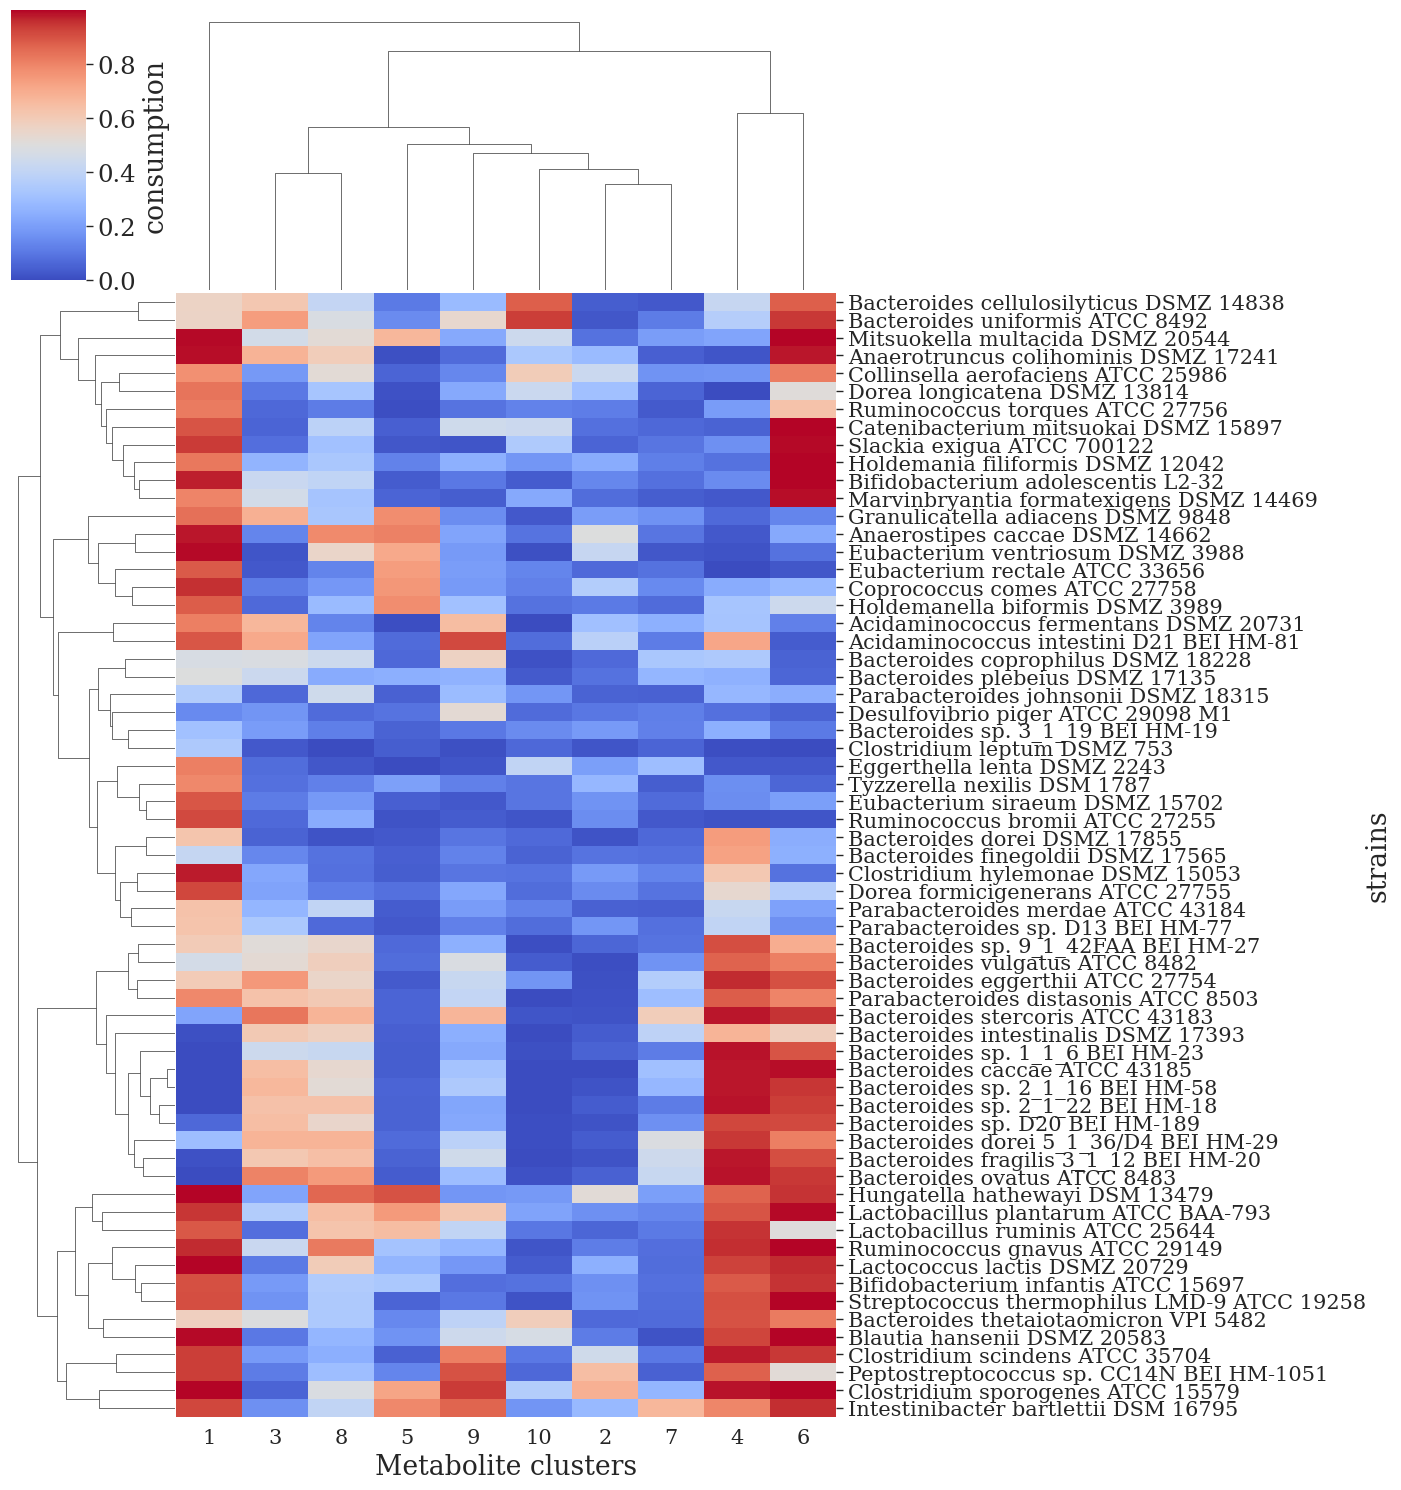

In [456]:
distance_metric = 'euclidean'
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')

plt_ = sns.clustermap(df_speciesMetab_cluster.iloc[:, range(nclusts)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True, \
                      cbar_kws={'shrink': 0.1, 'label': 'consumption'})

plt_.ax_heatmap.set_xlabel('Metabolite clusters')
plt_.ax_heatmap.set_ylabel('strains', labelpad=-1)

plt.setp(plt_.ax_heatmap.get_xticklabels(), rotation=0, fontsize=15)
plt.setp(plt_.ax_heatmap.get_yticklabels(), rotation=0, fontsize=15)
                           
# if want to save the plot as a figure provide a path to save the figure as a .svg
# file in the file_save variable
# plt_.savefig(file_save, \
#                     dpi=300, transparent=False, facecolor="white")


# 2. Fit metabolite concentrations $R_i$ using species abundances for passages 1 and 2 ($N_{\alpha}(\text{end of cycle}\, 1)$ and $N_{\alpha}(\text{end of cycle}\, 2)$, respectively)

2.1 If you want to re-compute the fitting of $R_i$ start from here. Otherwise, to use our provided fits of $R_i$, proceed to **section 2.3**. 

First fit $R_i$ with cross feeding term in Eq. (3) to get an initial estimate of $R_i$. We first assume that $N_{\alpha}(\text{grown alone}) = 0.1$

In [12]:
# fit Ri using 2 reps for passage 1 -> 2 transition and validate on 1 rep

In [13]:
rep_ = 0

In [440]:
num_passages = 6
reps_keep = [0, 1]
reps_rm = [2]
cols_keep = []
cols_keep_ratio = []
for rep_ in reps_keep:
    cols_keep += [i for i in range(rep_ * num_passages, (rep_ + 1) * num_passages)]
    cols_keep_ratio += [i for i in range(rep_ * (num_passages - 1), (rep_ + 1) * (num_passages - 1))]
df_speciesAbun_rep = df_speciesAbun.iloc[:, cols_keep].copy()
df_speciesAbun_prev_rep = df_speciesAbun_prev.iloc[:, cols_keep_ratio].copy()
df_speciesAbun_next_rep = df_speciesAbun_next.iloc[:, cols_keep_ratio].copy()
df_speciesAbun_ratio_rep = df_speciesAbun_ratio.iloc[:, cols_keep_ratio].copy()

cols_rm = []
cols_rm_ratio = []
for rep_ in reps_rm:
    cols_rm += [i for i in range(rep_ * num_passages, (rep_ + 1) * num_passages)]
    cols_rm_ratio += [i for i in range(rep_ * (num_passages - 1), (rep_ + 1) * (num_passages - 1))]
df_speciesAbun_val = df_speciesAbun.iloc[:, cols_rm].copy()
df_speciesAbun_prev_val = df_speciesAbun_prev.iloc[:, cols_rm_ratio].copy()
df_speciesAbun_next_val = df_speciesAbun_next.iloc[:, cols_rm_ratio].copy()
df_speciesAbun_ratio_val = df_speciesAbun_ratio.iloc[:, cols_rm_ratio].copy()

In [441]:
cols_rm

[12, 13, 14, 15, 16, 17]

In [442]:
df_speciesAbun_rep

,p1_r0,p2_r0,p3_r0,p4_r0,p5_r0,p6_r0,p1_r1,p2_r1,p3_r1,p4_r1,p5_r1,p6_r1
Acidaminococcus fermentans DSMZ 20731,3.180398e-02,1.232587e-04,6.704587e-06,1.964384e-05,2.923860e-04,6.674918e-04,3.751642e-02,1.509550e-04,2.801973e-04,3.247537e-03,2.649064e-02,6.867454e-03
Acidaminococcus intestini D21 BEI HM-81,2.174619e-01,2.143392e-01,3.034948e-01,2.783072e-01,2.449287e-01,2.852345e-01,2.173035e-01,1.983694e-01,2.674704e-01,3.043407e-01,2.476548e-01,2.650648e-01
Anaerostipes caccae DSMZ 14662,3.053745e-02,7.893345e-02,4.178763e-02,1.553076e-02,2.513826e-02,7.685045e-03,3.393580e-02,9.603154e-03,3.142386e-02,1.700029e-02,2.282783e-02,6.528065e-03
Anaerotruncus colihominis DSMZ 17241,7.641646e-05,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,9.158013e-05,1.277543e-06,2.257240e-07,1.000000e-08,8.028099e-08,1.000000e-08
Bacteroides caccae ATCC 43185,7.633257e-02,2.583468e-05,3.153010e-06,3.753517e-06,2.028774e-06,2.470496e-06,7.271956e-02,4.145522e-05,4.789548e-06,6.430825e-06,1.331149e-06,1.814534e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
Ruminococcus gnavus ATCC 29149,2.173690e-03,2.872359e-02,6.526354e-03,3.918121e-03,4.421267e-03,5.849030e-03,2.753382e-03,1.592495e-02,6.138713e-03,5.560732e-03,6.711834e-03,1.701515e-03
Ruminococcus torques ATCC 27756,2.727114e-04,9.021892e-05,2.965475e-06,4.094933e-06,1.882528e-05,1.090201e-05,2.477832e-04,3.475236e-05,5.534024e-05,1.792223e-05,6.581487e-05,4.976816e-05
Slackia exigua ATCC 700122,1.776472e-03,2.920661e-03,1.421295e-03,2.227100e-03,1.239252e-03,9.714653e-04,1.821668e-03,2.737841e-03,1.899006e-03,7.986064e-04,3.016710e-04,3.447447e-04
Streptococcus thermophilus LMD-9 ATCC 19258,3.879986e-07,1.000000e-08,8.662693e-08,1.000000e-08,1.000000e-08,1.000000e-08,6.177283e-07,1.000000e-08,1.000000e-08,1.459906e-07,1.000000e-08,1.000000e-08


In [443]:
# Only do this if you want to fit R_i yourself. Otherwise, you can load our fitted R_i as shown in section 2.3

#####uncomment to fit Ri yourself
rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new = [0.1] # this is one minus the time fraction. p = 1 - f. We use f = 0.9 in the manuscript

N_alone = 0.1 # N_{\alpha}(\text{grown alone})
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()


save_data = False
num_passages = 6
num_transitions = num_passages - 1
num_brep = 2

# passages transitions to remove for fitting R_i. There are 5 passage transitions for 6 passages.
# we only keep the first transition. Passages are indexed starting from 0 as is the python convention.
pass_rm = np.arange(0, num_passages - 1)
pass_rm = np.setdiff1d(pass_rm, [0])
Ri_dynamic_obj, A_train, b_train = \
    fit_dynamic_Ri(df_speciesMetab_tmp, \
                    df_speciesAbun_prev_rep.copy(), \
                    df_speciesAbun_next_rep.copy(), \
                    df_speciesAbun_ratio_rep.copy(), p_vec_new, \
                    file_save=None, num_passages=num_transitions, pass_rm=pass_rm, num_brep=num_brep, \
                    get_prod=True, B_alone=N_alone, \
                    df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
                    prod_use_prev=False, use_dilution_term=True, \
                    dilution_factor=15000, use_avg_for_prod=False, \
                    return_raw_data=True, check_ratio_dir=False, save_data=save_data)

####BEGIN: Save fitted R_i. For saving data uncomment the following lines
# save_data = True
# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', "review1"))
# date_ = "20240720"
# file_save = os.path.abspath(os.path.join(save_dir, 
#                                          f'{date_}_Ri_fit_dynamic_with_production' + \
#                                          f'_cluster_metabolites_hierachClust_' + \
#                                          f'colShuffledConsMat.pickle'))
# with open(file_save, "wb") as file_:
#      pickle.dump(Ri_dynamic_obj, file_) 
####END: Save data.



count = 0, p_tmp = 0.1


In [444]:
pass_rm

array([1, 2, 3, 4])

2.2 Now, iteratively estimate $R_i$ and $N_{\alpha}(\text{grown alone})$ using the species abundance data for the first two passages.$B_{alone}$ and $N_{alone}$ are used synonymously.

In [445]:
# fit Ri with production and iteratively find B_alone

#####uncomment to fit Ri yourself
num_iter = 10
N_alone_iter = {}

rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new = [0.1]
count_p = 0

# initialize Ri_0
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'].copy()
count_p = 0
Ri_0_init_new = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()

num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()

Ri_dynamic_obj = {}
num_passages = 6
num_passage_transitions = num_passages - 1
pass_keep = np.arange(num_passage_transitions)
# id_keep = list(pass_keep) + list(pass_keep + num_passage_transitions) + \
#     list(pass_keep + 2 * (num_passage_transitions))
id_keep = list(pass_keep) + list(pass_keep + num_passage_transitions)
# pass_rm = np.arange(1, num_passage_transitions)
pass_rm = np.arange(0, num_passage_transitions)
pass_rm = np.setdiff1d(pass_rm, [0])

RMSE_Balone_iterate = {}
id_species_keep = np.arange(df_speciesAbun_rep.shape[0])

for iter_ in range(num_iter):
    print(f'iteration = {iter_}')
    if iter_ == 0:
        Ri_avg = Ri_0_init_new.copy()
        
        # use approximation from the paper to get N_alone once R_i is known
        N_alone_cur = get_B_alone_func(Ri_avg, \
                                       df_speciesMetab_cluster.iloc[id_species_keep, :].copy())
    else:
        Ri_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0].copy()
        N_alone_cur = N_alone_iter[iter_ - 1].copy()
    
    
    Ri_dynamic_obj, A_train, b_train = \
        fit_dynamic_Ri(df_speciesMetab_tmp.iloc[id_species_keep, :], \
                        df_speciesAbun_prev_rep.iloc[:, id_keep].copy(), \
                        df_speciesAbun_next_rep.iloc[:, id_keep].copy(), \
                        df_speciesAbun_ratio_rep.iloc[:, id_keep].copy(), p_vec_new, \
                        file_save="", num_passages=num_passage_transitions, \
                        pass_rm=pass_rm, save_data=False, \
                        num_brep=num_brep, \
                        get_prod=True, B_alone=N_alone_cur, \
                        df_speciesMetab_prod=df_speciesMetab_prod_tmp.iloc[id_species_keep, :], \
                        prod_use_prev=False, use_avg_for_prod=False, \
                        return_raw_data=True, check_ratio_dir=False)
    Ri_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0].copy()
    N_alone_iter[iter_] = get_B_alone_func(Ri_avg, \
                                           df_speciesMetab_cluster.iloc[id_species_keep, :].copy())
    RMSE_Balone_iterate[iter_] = \
        get_RMSE_Balone_func(df_speciesMetab_cluster.iloc[id_species_keep, :], \
                                df_speciesMetab_prod_cluster.iloc[id_species_keep, :], \
                                p_vec_new, 0, \
                                Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'].copy(), \
                                df_speciesAbun_inoc.iloc[id_species_keep, :], \
                                df_speciesAbun_rep, df_speciesAbun_prev_rep, \
                                df_speciesAbun_ratio_rep, N_alone_cur, num_passages=6, \
                                use_dilution=True, n_breps=num_brep)
Ri_dynamic_obj['B_alone_iter'] = N_alone_iter #B_alone and N_alone are used synonymously

# BEGIN: to save the data uncomment the following lines
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', "review1", \
                                        "fit2reps_pass1to2_pred1rep"))
date_ = "20240721"
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_review1_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_hierachClust' + \
                                         f'_iterate_Nalone_fit2reps_pass1to2_pred1rep.pickle'))
with open(file_save, "wb") as file_:
     pickle.dump(Ri_dynamic_obj, file_)
# END: to save the data uncomment the following lines

iteration = 0
count = 0, p_tmp = 0.1
iteration = 1
count = 0, p_tmp = 0.1
iteration = 2
count = 0, p_tmp = 0.1
iteration = 3
count = 0, p_tmp = 0.1
iteration = 4
count = 0, p_tmp = 0.1
iteration = 5
count = 0, p_tmp = 0.1
iteration = 6
count = 0, p_tmp = 0.1
iteration = 7
count = 0, p_tmp = 0.1
iteration = 8
count = 0, p_tmp = 0.1
iteration = 9
count = 0, p_tmp = 0.1


In [338]:
# BEGIN: to save the data uncomment the following lines
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', "review1", \
                                        "fit2reps_pass1to2_pred1rep"))
date_ = "20240721"
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_review1_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_hierachClust' + \
                                         f'_iterate_Nalone_fitReps12_pass1to2_predRep3.pickle'))
# load Ri_dynamic_obj from file
with open(file_save, "rb") as file_:
    Ri_dynamic_obj = pickle.load(file_)
# END: to save the data uncomment the following lines

2.3 Using the estimated $R_i$ and $N_{\alpha}(\text{grown alone})$, run the dynamical model in forward starting from the inoculum

In [446]:
Ri_noMicrocosm_dynamicAll_fit_all = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_all']
Ri_noMicrocosm_dynamicAll_fit_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_avg']
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint']
N_alone_iter = Ri_dynamic_obj['B_alone_iter']

In [447]:
passage_pred = 1
df_speciesAbun_val_tmp = df_speciesAbun_val.iloc[:, passage_pred:].copy()
df_speciesAbun_prev_val_tmp = df_speciesAbun_prev_val.iloc[:, passage_pred:].copy()
df_speciesAbun_next_val_tmp = df_speciesAbun_next_val.iloc[:, passage_pred:].copy()
df_speciesAbun_ratio_val_tmp = df_speciesAbun_ratio_val.iloc[:, passage_pred:].copy()
df_speciesAbun_inoc_tmp = pd.DataFrame(data=df_speciesAbun_val.iloc[:, passage_pred - 1].copy().values)
df_speciesAbun_inoc_tmp.columns = [df_speciesAbun_val.columns[passage_pred - 1]]

In [448]:
df_speciesAbun_prev_val_tmp

,p3_r2,p4_r2,p5_r2,p6_r2
0,6.802839e-04,2.546092e-04,1.037398e-04,1.317724e-04
1,2.045056e-01,2.981957e-01,3.043595e-01,3.054243e-01
2,4.933659e-03,1.727806e-02,7.776625e-03,6.220632e-02
3,7.965272e-07,1.000000e-08,1.000000e-08,1.000000e-08
4,1.118852e-04,1.638908e-04,2.938171e-06,5.076057e-06
...,...,...,...,...
58,9.989043e-03,3.268566e-03,2.781552e-03,6.712029e-03
59,3.758673e-05,4.198384e-05,3.080377e-05,1.010013e-05
60,2.531160e-03,3.458196e-03,4.025108e-03,1.840863e-03
61,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08


In [449]:
df_speciesAbun_inoc_tmp

,p1_r2
0,4.710307e-02
1,1.584982e-01
2,3.420288e-02
3,7.865395e-05
4,6.615639e-02
...,...
58,3.988645e-03
59,2.444333e-04
60,2.231052e-03
61,8.277804e-07


In [450]:
# evalute Ri with production and iterative Nalone to predict abundances starting with inoculum
num_iter = 10
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
count_p = 7
# num_iter = 20
p_vec_new_tmp = [p_vec_new[count_p]]
count_p = 0
num_passages_val = 5
RMSE_mat_full = np.zeros((num_passages_val - 1, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# Ri_fit = {0: Ri_pass1.copy()}
# Ri_0 = {0: Ri_inoc.copy()}
id_species_keep = np.arange(df_speciesAbun_rep.shape[0])
abun_alone = get_B_alone_func(Ri_avg, df_speciesMetab_cluster.iloc[id_species_keep, :].copy())
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all_prod, RMSE_obj_all_prod = \
    blindly_pred_abun_growth([p_vec_new_tmp[count_p]], \
                                df_speciesMetab_tmp.iloc[id_species_keep, :], \
                                df_speciesAbun_inoc_tmp.iloc[id_species_keep, :].copy(), \
                                df_speciesAbun_val_tmp.copy(), \
                                df_speciesAbun_prev_val_tmp.copy(), \
                                df_speciesAbun_ratio_val_tmp.copy(), \
                                Ri_fit.copy(), "dummy", "dummy", \
                                "dummy", num_passages=num_passages_val, num_iter=100, \
                                thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                                save_data_obj=False, \
                                return_sensitivity_ana=True, \
                                get_prod=True, B_alone=N_alone_iter[num_iter - 2].copy(), \
                                df_speciesMetab_prod=df_speciesMetab_prod_tmp.iloc[id_species_keep, :], \
                                prod_use_prev=False, use_dilution=True, dilution_factor=15000, \
                                use_avg_for_prod=False, Ri_0=None, n_breps=1, \
                                num_passages_run=num_passages_val)
for pass_ in range(num_passages_val - 1):
    RMSE_mat_full[pass_, 0] = RMSE_obj_all_prod[pass_]["abundance"]
    RMSE_mat_full[pass_, 1] = RMSE_obj_all_prod[pass_]["growth_ratio"]

In [451]:
RMSE_mat_full

array([[1.29020518, 1.28926298],
       [2.30704626, 1.8479945 ],
       [2.9078354 , 2.01945321],
       [3.05733493, 1.89627488]])

In [207]:
len(sens_obj_all_prod[pass_]['df_speciesAbun_next_obs'].copy())

63

In [208]:
np.arange(num_species) * 3 + 1

array([  1,   4,   7,  10,  13,  16,  19,  22,  25,  28,  31,  34,  37,
        40,  43,  46,  49,  52,  55,  58,  61,  64,  67,  70,  73,  76,
        79,  82,  85,  88,  91,  94,  97, 100, 103, 106, 109, 112, 115,
       118, 121, 124, 127, 130, 133, 136, 139, 142, 145, 148, 151, 154,
       157, 160, 163, 166, 169, 172, 175, 178, 181, 184, 187])

## Fig 2 shuffled

row = 0, col = 0
RMSE high-mid abundance = 1.2726567141617113
row = 0, col = 1
RMSE high-mid abundance = 2.8813931440856795


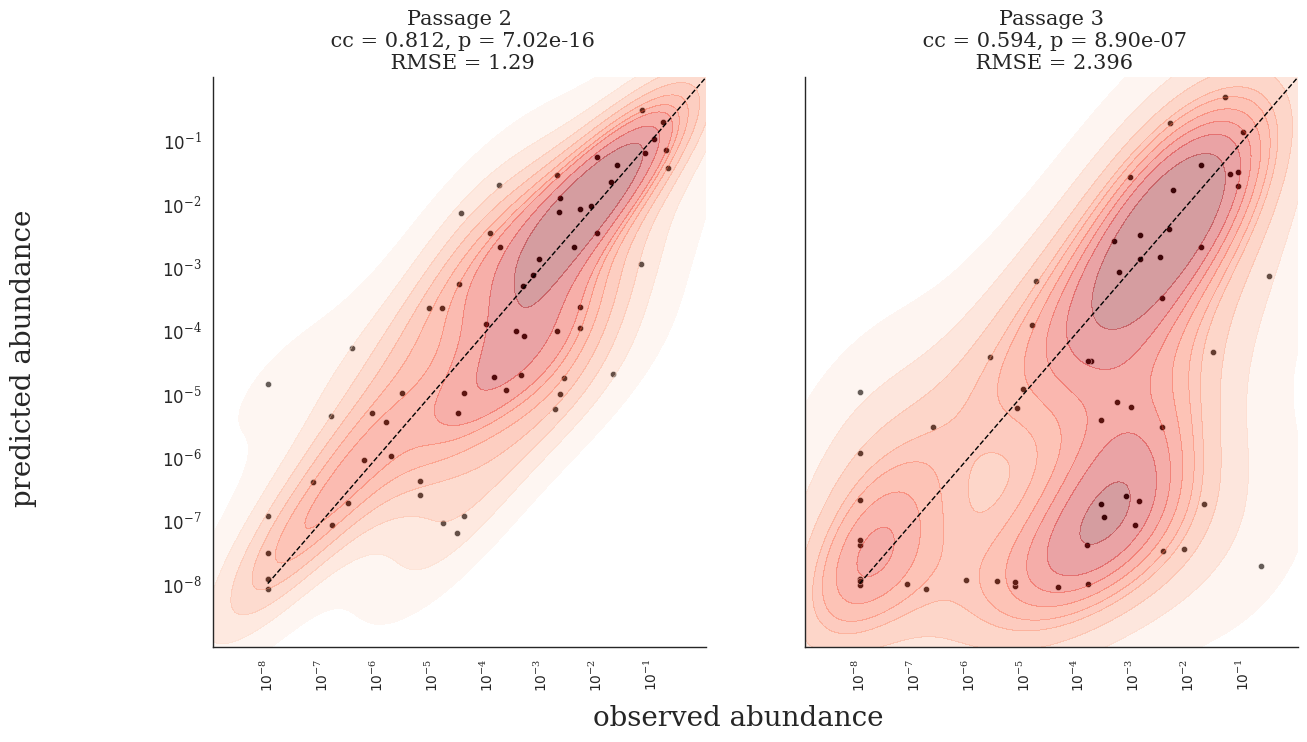

In [452]:
# Figure 2 for paper: prediction performance with production and iterative Balone

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(1, 2, figsize=(14, 7.4), sharey="row", sharex="col")
# axes = [axes_all]
fig.supylabel('predicted abundance', fontsize=20, x=-0.02, y=0.5)
fig.supxlabel('observed abundance', fontsize=20, x=0.5, y=-0.005)
df_pred_vs_obs = pd.DataFrame(data={'passage' : [], \
                                    'species' : [], \
                                    'predicted_abundance' : [], \
                                    'mean_observed_abundance' : [], \
                                    'min_observed_abundance' : [], \
                                    'max_observed_abundance' : []})
num_passages_test = 2
n_breps_test = 1
max_to_min_pass = [None] * num_passages_test
abun_pred_pass = [None] * num_passages_test
abun_linear_pred_pass = [None] * num_passages_test
abun_orig_pass = [None] * num_passages_test
abun_orig_pass_rep = [None] * num_passages_test
sd_orig_pass = [None] * num_passages_test
RMSE_pred = [None] * num_passages_test
y_pred = {}
for pass_ in range(num_passages_test):
    ax_row_ = int(pass_ / num_passages_test)
    ax_col_ = int(pass_ % num_passages_test)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(n_breps_test)
    x_f = sens_obj_all_prod[pass_]['df_speciesAbun_next_obs'].copy()
    x_f = x_f.flatten()
    y_f = sens_obj_all_prod[pass_]['df_speciesAbun_next_pred'].copy()
    thresh_zero = 1e-8
    y_f[y_f <= thresh_zero] = thresh_zero
    x_f[x_f <= thresh_zero] = thresh_zero

    y_pred[pass_] = y_f.copy()

    x = np.zeros((num_species))
    x_min = np.zeros((num_species))
    x_max = np.zeros((num_species))
    y = np.zeros((num_species))
    sd_orig_pass[pass_] = np.zeros((num_species))
    RMSE_pred[pass_] = np.zeros((num_species))
    abun_linear_pred_pass[pass_] = np.zeros((num_species))
    abun_orig_pass_rep[pass_] = np.zeros((num_species, 3))
    for rep_ in range(n_breps_test):
        id_ = np.arange(num_species) * n_breps_test + rep_
        abun_orig_pass_rep[pass_][:, rep_] = np.log10(x_f[id_])
    id_species_keep = []
    for species_ in range(num_species):
        # id_ = np.array([0, 1, 2]) + species_ * 3
        if pass_ != 0:
            # id_pass = [pass_ - 1]
            ratio_ = df_speciesAbun_ratio_val_tmp.iloc[species_, pass_ - 1]
        else:
            ratio_ = df_speciesAbun_prev_val_tmp.iloc[species_, 0] / \
                df_speciesAbun_inoc_tmp.iloc[species_, 0]
            if (ratio_ == 1) & (df_speciesAbun_prev_val_tmp.iloc[species_, 0] <= 1e-8):
                ratio_ = -1
        if ratio_ > 0:
            id_species_keep.append(species_)
        id_ = np.array([0]) + species_ * n_breps_test
        x[species_] = np.exp(np.mean(np.log(x_f[id_])))
        x_min[species_] = np.min(x_f[id_])
        x_max[species_] = np.max(x_f[id_])
        y[species_] = np.exp(np.mean(np.log(y_f[id_])))
        abun_linear_pred_pass[pass_][species_] = np.mean(x_f[id_])

        sd_orig_pass[pass_][species_] = np.sqrt(np.var((x_f[id_])))
        RMSE_pred[pass_][species_] = np.sqrt(np.mean(np.power(np.log10(x_f[id_]) - \
                                                    np.log10(y_f[id_]), 2)))
        
    x = np.log10(x[id_species_keep])
    x_min = np.log10(x_min[id_species_keep])
    x_max = np.log10(x_max[id_species_keep])
    y = np.log10(y[id_species_keep])
    y_orig = y.copy()
    
    id_filter = np.where(x >= -3)[0]
    RMSE_tmp = np.sqrt(np.mean(np.power(y_orig[id_filter] - x[id_filter], 2)))
    print(f'RMSE high-mid abundance = {RMSE_tmp}')
    
    id_ = np.where(y <= -7.99)[0]
    noise_ = np.random.choice([-4, -3, -2, -1, 0, 1, 2, 3, 4], len(id_), replace=True)
    y[id_] += noise_ / 50
    
    # df_pred_vs_obs_tmp = pd.DataFrame(data={'passage' : [pass_] * len(x), \
    #                                   'species' : species_names[:].flatten(), \
    #                                   'predicted_abundance (log10)' : y, \
    #                                   'mean_observed_abundance (log10)' : x, \
    #                                   'min_observed_abundance (log10)' : x_min, \
    #                                   'max_observed_abundance (log10)' : x_max})
    # max_to_min_pass[pass_] = x_max.copy() - x_min.copy()
    # abun_pred_pass[pass_] = y_orig.copy()
    # abun_orig_pass[pass_] = x.copy()
    # if pass_ == 0:
    #     df_pred_vs_obs = df_pred_vs_obs_tmp.copy()
    # else:
    #     df_pred_vs_obs = pd.concat((df_pred_vs_obs, df_pred_vs_obs_tmp), axis=0)
    
    def error_bar_(x):
        return (np.min(x), np.max(x))

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=20, ax=axes[ax_col_], c="black")
    # xerr=np.vstack([x_max.flatten() - x.flatten(), \
    #                 x.flatten() - x_min.flatten()])
    # xerr[xerr < 0] = 0
    # axes[ax_col_].errorbar(x=x, y=y, yerr=None, \
    #                                 xerr=xerr, \
    #                                fmt='none', elinewidth=0.2, c="black", \
    #                       capsize=3)

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.4, cmap="Reds", \
                    ax=axes[ax_col_])
    plt_.plot([-8, 0], [-8, 0], c="black", linewidth=1, ls="dashed")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y_orig)
    corr_val_pe_log = scipy.stats.pearsonr(x, y_orig)
    corr_val_sp = scipy.stats.spearmanr(x, y_orig)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y_orig - x, 2)))
    std_error = np.sqrt(np.std(np.power(y_orig - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y_orig, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    title_ = f'Passage {pass_ + 2}' + \
            f'\n cc = {np.round(corr_val_pe_log[0], 3)}, p = ' + \
                    '{:.2e}'.format(corr_val_pe_log[1]) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'
    # title_ = f'Passage {pass_ + 1}' + \
    #         f'\n cc = {np.round(corr_val_pe[0], 3)}, p = ' + \
    #                 '{:.2e}'.format(corr_val_pe[1]) + \
    #         f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_col_].set_title(title_, size=15)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        yticks_ = np.arange(-8, 0, step=1)
        ylabs_ = []
        for y_ in yticks_:
            ylabs_.append(fr"${10}^{{\mathregular{{{y_}}}}}$")
        plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=9)
    if ax_row_ == 0:
        xticks_ = np.arange(-8, 0, step=1)
        xlabs_ = []
        for x_ in xticks_:
            xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
#             plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
        plt_.set_xticks(xticks_, labels=xlabs_, fontsize=10)
        axes[ax_col_].tick_params(axis='x', rotation=90) 
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsiz
#         plt_.set_xticks(np.arange(-10, 1, step=2))
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=9)
    axes[ax_col_].set_xlim(-9, 0)
    axes[ax_col_].set_ylim(-9, 0)
        
    plt_ = sns.despine(right=True, top=True, ax=axes[ax_col_])

# BEGIN: to save figure to svg
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', "review1", \
                                        "fit2reps_pass1to2_pred1rep"))
date_ = "20240721"
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_review1_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_hierachClust' + \
                                         f'_iterate_Nalone_fitReps31_pass1to2_predRep2_predAbun_logCorr.svg'))
# fig.savefig(file_save, \
#                     dpi=300, transparent=False, facecolor="white")

In [131]:
sens_obj_all_prod[pass_]['growth_ratio_all'].values.flatten()

array([5.22415688e-02, 8.70887623e-01, 4.98304129e-01, 5.92535856e-03,
       3.42966522e-03, 3.10822163e-02, 1.32652064e+00, 2.69537451e-02,
       7.90462448e-02, 3.69869871e-01, 9.93329258e-02, 2.60549892e-01,
       5.05561277e-02, 3.67093398e+00, 7.18712957e-02, 1.29478262e-01,
       1.06583281e-01, 9.12441165e-01, 6.66676805e-02, 8.40611272e-01,
       1.69987513e-02, 2.78090750e-01, 8.15401675e-01, 1.44730109e+00,
       1.26980659e-01, 2.14930773e+00, 1.22348435e-01, 1.59254341e-01,
       1.65451052e-03, 5.96037704e-01, 2.25121197e-04, 5.76797099e-01,
       1.27707450e+00, 9.18134875e-01, 5.89726943e-03, 1.16749928e-02,
       1.34440632e-01, 1.97730135e-02, 8.87223895e-03, 2.44298166e-01,
       8.30284380e-03, 1.48000515e-02, 1.53996206e-01, 7.99710178e-03,
       7.49721506e-03, 5.57423782e-01, 2.00671376e-02, 5.50305937e-02,
       3.23249136e-03, 2.19092190e-03, 6.83136317e-03, 8.55702001e-01,
       1.82631786e-01, 1.04617466e-03, 1.30315367e+00, 2.74828123e-01,
      

row = 0, col = 0
RMSE high-mid abundance = 0.8299060360251469
row = 0, col = 1
RMSE high-mid abundance = 1.2626065815184089


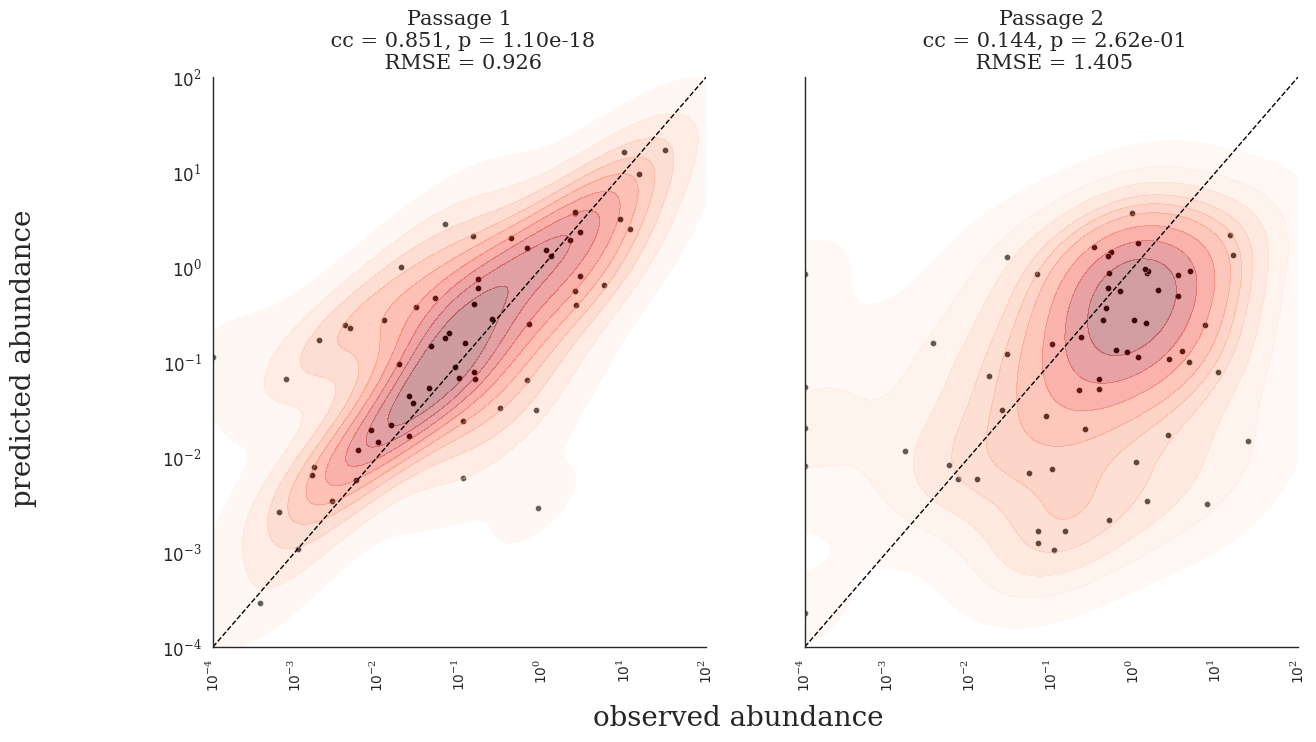

In [348]:
# Figure 2 for paper: prediction performance with production and iterative Balone

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(1, 2, figsize=(14, 7.4), sharey="row", sharex="col")
# axes = [axes_all]
fig.supylabel('predicted abundance', fontsize=20, x=-0.02, y=0.5)
fig.supxlabel('observed abundance', fontsize=20, x=0.5, y=-0.005)
df_pred_vs_obs = pd.DataFrame(data={'passage' : [], \
                                    'species' : [], \
                                    'predicted_abundance' : [], \
                                    'mean_observed_abundance' : [], \
                                    'min_observed_abundance' : [], \
                                    'max_observed_abundance' : []})
num_passages_test = 2
n_breps_test = 1
max_to_min_pass = [None] * num_passages_test
abun_pred_pass = [None] * num_passages_test
abun_linear_pred_pass = [None] * num_passages_test
abun_orig_pass = [None] * num_passages_test
abun_orig_pass_rep = [None] * num_passages_test
sd_orig_pass = [None] * num_passages_test
RMSE_pred = [None] * num_passages_test
x_ratio = {}
for pass_ in range(num_passages_test):
    ax_row_ = int(pass_ / num_passages_test)
    ax_col_ = int(pass_ % num_passages_test)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(n_breps_test)
    x_f = sens_obj_all_prod[pass_]['growth_ratio_obs'].copy().flatten()
    x_f = x_f.flatten()
    x_ratio[pass_] = x_f.copy()
    y_f = sens_obj_all_prod[pass_]['growth_ratio_all'].copy().values.flatten()
    thresh_zero = 1e-4
    y_f[y_f <= thresh_zero] = thresh_zero
    x_f[x_f <= thresh_zero] = thresh_zero

    x = np.zeros((num_species))
    x_min = np.zeros((num_species))
    x_max = np.zeros((num_species))
    y = np.zeros((num_species))
    sd_orig_pass[pass_] = np.zeros((num_species))
    RMSE_pred[pass_] = np.zeros((num_species))
    abun_linear_pred_pass[pass_] = np.zeros((num_species))
    abun_orig_pass_rep[pass_] = np.zeros((num_species, 3))
    for rep_ in range(n_breps_test):
        id_ = np.arange(num_species) * n_breps_test + rep_
        abun_orig_pass_rep[pass_][:, rep_] = np.log10(x_f[id_])
    for species_ in range(num_species):
        # id_ = np.array([0, 1, 2]) + species_ * 3
        id_ = np.array([0]) + species_ * n_breps_test
        x[species_] = np.exp(np.mean(np.log(x_f[id_])))
        x_min[species_] = np.min(x_f[id_])
        x_max[species_] = np.max(x_f[id_])
        y[species_] = np.exp(np.mean(np.log(y_f[id_])))
        abun_linear_pred_pass[pass_][species_] = np.mean(x_f[id_])

        sd_orig_pass[pass_][species_] = np.sqrt(np.var((x_f[id_])))
        RMSE_pred[pass_][species_] = np.sqrt(np.mean(np.power(np.log10(x_f[id_]) - \
                                                    np.log10(y_f[id_]), 2)))
    
    id_ = np.where(x > 0)[0]
    x = np.log10(x[id_])
    x_min = np.log10(x_min)
    x_max = np.log10(x_max)
    y = np.log10(y[id_])
    y_orig = y.copy()
    
    id_filter = np.where(x >= -3)[0]
    RMSE_tmp = np.sqrt(np.mean(np.power(y_orig[id_filter] - x[id_filter], 2)))
    print(f'RMSE high-mid abundance = {RMSE_tmp}')
    
    # id_ = np.where(y <= -7.99)[0]
    # noise_ = np.random.choice([-4, -3, -2, -1, 0, 1, 2, 3, 4], len(id_), replace=True)
    # y[id_] += noise_ / 50
    
    # df_pred_vs_obs_tmp = pd.DataFrame(data={'passage' : [pass_] * len(x), \
    #                                   'species' : species_names[:].flatten(), \
    #                                   'predicted_abundance (log10)' : y, \
    #                                   'mean_observed_abundance (log10)' : x, \
    #                                   'min_observed_abundance (log10)' : x_min, \
    #                                   'max_observed_abundance (log10)' : x_max})
    max_to_min_pass[pass_] = x_max.copy() - x_min.copy()
    abun_pred_pass[pass_] = y_orig.copy()
    abun_orig_pass[pass_] = x.copy()
    # if pass_ == 0:
    #     df_pred_vs_obs = df_pred_vs_obs_tmp.copy()
    # else:
    #     df_pred_vs_obs = pd.concat((df_pred_vs_obs, df_pred_vs_obs_tmp), axis=0)
    
    def error_bar_(x):
        return (np.min(x), np.max(x))

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=20, ax=axes[ax_col_], c="black")
    xerr=np.vstack([x_max.flatten() - x.flatten(), \
                    x.flatten() - x_min.flatten()])
    xerr[xerr < 0] = 0
    # axes[ax_col_].errorbar(x=x, y=y, yerr=None, \
    #                                 xerr=xerr, \
    #                                fmt='none', elinewidth=0.2, c="black", \
    #                       capsize=3)

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.4, cmap="Reds", \
                    ax=axes[ax_col_])
    plt_.plot([-4, 2], [-4, 2], c="black", linewidth=1, ls="dashed")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y_orig)
    corr_val_pe_log = scipy.stats.pearsonr(x, y_orig)
    corr_val_sp = scipy.stats.spearmanr(x, y_orig)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y_orig - x, 2)))
    std_error = np.sqrt(np.std(np.power(y_orig - x, 2)))

    id_notzero_zero = np.where((x > -4) & (y <= -4))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y_orig, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    title_ = f'Passage {pass_ + 1}' + \
            f'\n cc = {np.round(corr_val_pe_log[0], 3)}, p = ' + \
                    '{:.2e}'.format(corr_val_pe_log[1]) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'
    title_ = f'Passage {pass_ + 1}' + \
            f'\n cc = {np.round(corr_val_pe[0], 3)}, p = ' + \
                    '{:.2e}'.format(corr_val_pe[1]) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_col_].set_title(title_, size=15)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        yticks_ = np.arange(-4, 3, step=1)
        ylabs_ = []
        for y_ in yticks_:
            ylabs_.append(fr"${10}^{{\mathregular{{{y_}}}}}$")
        plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=9)
    if ax_row_ == 0:
        xticks_ = np.arange(-4, 3, step=1)
        xlabs_ = []
        for x_ in xticks_:
            xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
#             plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
        plt_.set_xticks(xticks_, labels=xlabs_, fontsize=10)
        axes[ax_col_].tick_params(axis='x', rotation=90) 
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsiz
#         plt_.set_xticks(np.arange(-10, 1, step=2))
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=9)
    axes[ax_col_].set_xlim(-4, 2)
    axes[ax_col_].set_ylim(-4, 2)
        
    plt_ = sns.despine(right=True, top=True, ax=axes[ax_col_])

# BEGIN: to save figure to svg
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', "review1", \
                                        "fit2reps_pass1to2_pred1rep"))
date_ = "20240721"
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_review1_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_hierachClust' + \
                                         f'_iterate_Nalone_fitReps12_pass1to2_predRep3_predGrowth_linCorr.svg'))
fig.savefig(file_save, \
                    dpi=300, transparent=False, facecolor="white")

In [249]:
df_speciesAbun_ratio

,p2_r0,p3_r0,p4_r0,p5_r0,p6_r0,p2_r1,p3_r1,p4_r1,p5_r1,p6_r1,p2_r2,p3_r2,p4_r2,p5_r2,p6_r2
0,0.003876,0.054394,2.929911,14.884362,2.282912,0.004024,1.856165,11.590179,8.157147,0.259241,0.014442,0.374269,0.407447,1.270221,2.119863
1,0.985640,1.415955,0.917008,0.880066,1.164562,0.912868,1.348345,1.137848,0.813742,1.070299,1.290270,1.458130,1.020670,1.003499,0.895876
2,2.584808,0.529403,0.371659,1.618611,0.305711,0.282980,3.272243,0.540999,1.342791,0.285970,0.144247,3.502078,0.450087,7.999140,0.135832
3,0.000131,-1.000000,-1.000000,-1.000000,-1.000000,0.013950,0.176686,0.044302,8.028099,0.124562,0.010127,0.012554,-1.000000,-1.000000,15.756017
4,0.000338,0.122046,1.190455,0.540500,1.217728,0.000570,0.115535,1.342679,0.206995,1.363133,0.001691,1.464812,0.017928,1.727624,0.397667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,13.214210,0.227212,0.600354,1.128415,1.322931,5.783778,0.385478,0.905847,1.207005,0.253510,2.504370,0.327215,0.851001,2.413052,0.873243
59,0.330822,0.032870,1.380869,4.597213,0.579116,0.140253,1.592417,0.323855,3.672248,0.756184,0.153771,1.116986,0.733706,0.327886,8.852359
60,1.644080,0.486635,1.566951,0.556442,0.783912,1.502931,0.693614,0.420539,0.377747,1.142784,1.134514,1.366250,1.163933,0.457345,0.601556
61,0.025773,8.662693,0.115438,-1.000000,-1.000000,0.016188,-1.000000,14.599057,0.068498,-1.000000,0.012080,-1.000000,-1.000000,-1.000000,-1.000000


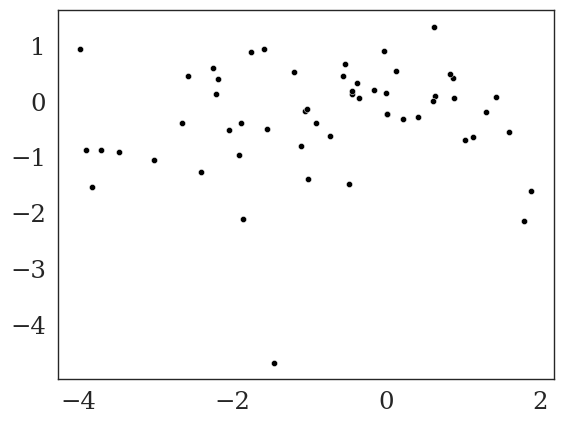

In [356]:
x1 = x_ratio[0].copy()
x2 = x_ratio[1].copy()
x1 = df_speciesAbun_ratio.iloc[:, 0].values.copy()
x2 = df_speciesAbun_ratio.iloc[:, 1].values.copy()
id_ = np.where((x1 > 0) & (x2 > 0))[0]
x1 = np.log10(x1[id_])
x2 = np.log10(x2[id_])
plt_ = sns.scatterplot(x=x1, \
                        y=x2, s=20, c="black")

In [357]:
from scipy.stats import gaussian_kde
from scipy.integrate import quad

def compute_entropy(data, num_points=1000):
    # Estimate the PDF using Gaussian Kernel Density Estimation
    kde = gaussian_kde(data)
    
    # Define a function that returns the PDF value for a given point
    pdf = lambda x: kde(x)
    
    # Define the function for the integrand
    def integrand(x):
        p_x = pdf(x)
        return -p_x * np.log(p_x)
    
    # Generate points to evaluate the entropy
    x_min, x_max = min(data), max(data)
    points = np.linspace(x_min, x_max, num_points)
    
    # Compute the entropy by integrating the integrand over the range of data
    entropy, _ = quad(integrand, x_min, x_max)
    
    return entropy

In [403]:
num_bioRep = 3
num_passages = 5    
for rep_num in range(num_bioRep):
    x1 = df_speciesAbun_ratio.iloc[:, 0 + rep_num * num_passages].values.copy()
    x2 = df_speciesAbun_ratio.iloc[:, 1 + rep_num * num_passages].values.copy()
    # x3 = df_speciesAbun_ratio.iloc[:, 2 + rep_num * num_passages].values.copy()
    id_ = np.where((x1 > 0) & (x2 > 0))[0]
    x1 = np.log10(x1[id_])
    x2 = np.log10(x2[id_])

    # Calculate common bin edges
    min_edge = min(x1.min(), x2.min())
    max_edge = max(x1.max(), x2.max())
    bins = np.linspace(min_edge, max_edge, 10)  # 30 bins as an example

    fig, axes = plt.subplots(2, 1, figsize=(7, 10), sharey="row", sharex="col")
    plt_ = sns.histplot(x1, bins=bins, kde=True, color='blue', ax=axes[0])
    rmsd1 = np.sqrt(np.mean(np.power(x1 - 0, 2)))
    print(rmsd1)
    # print(compute_entropy(x2))
    plt_.set_ylabel('# strains', fontsize=15)
    plt_.set_title(f'Passage 1->2\n RMSD={rmsd1:.2f}', fontsize=15)
    # print(compute_entropy(x1))
    plt_ = sns.histplot(x2, bins=bins, kde=True, color='green', ax=axes[1])
    rmsd2 = np.sqrt(np.mean(np.power(x2 - 0, 2)))
    print(rmsd2)
    # print(compute_entropy(x2))
    plt_.set_ylabel('# strains', fontsize=15)
    plt_.set_title(f'Passage 2->3\n RMSD={rmsd2:.2f}', fontsize=15)

    xticks_ = np.arange(-5, 3, step=1)
    xlabs_ = []
    for x_ in xticks_:
        xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
#             plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
    axes[1].set_xticks(xticks_, labels=xlabs_, fontsize=10)
    axes[1].tick_params(axis='x', rotation=90) 
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsiz
#         plt_.set_xticks(np.arange(-10, 1, step=2))
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=9)
    axes[0].set_xlim(-5, 2.5)
    axes[1].set_xlim(-5, 2.5)

    # BEGIN: to save figure to svg
    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', "review1", \
                                            "fit2reps_pass1to2_pred1rep"))
    date_ = "20240721"
    file_save = os.path.abspath(os.path.join(save_dir, 
                                            f'{date_}_for_paper_review1_hist_growthRatioObs_rep{rep_num}.svg'))
    fig.savefig(file_save, \
                        dpi=300, transparent=False, facecolor="white")
    plt.close()

1.7454689535583288
1.0206952020633862
1.5737178109526802
0.770709212710899
1.4772674158760557
1.0189793484482383


In [400]:
rep_num * num_passages

12

row = 0, col = 0
RMSE high-mid abundance = 1.3938303025898893
row = 0, col = 1
RMSE high-mid abundance = 1.5469532478337844


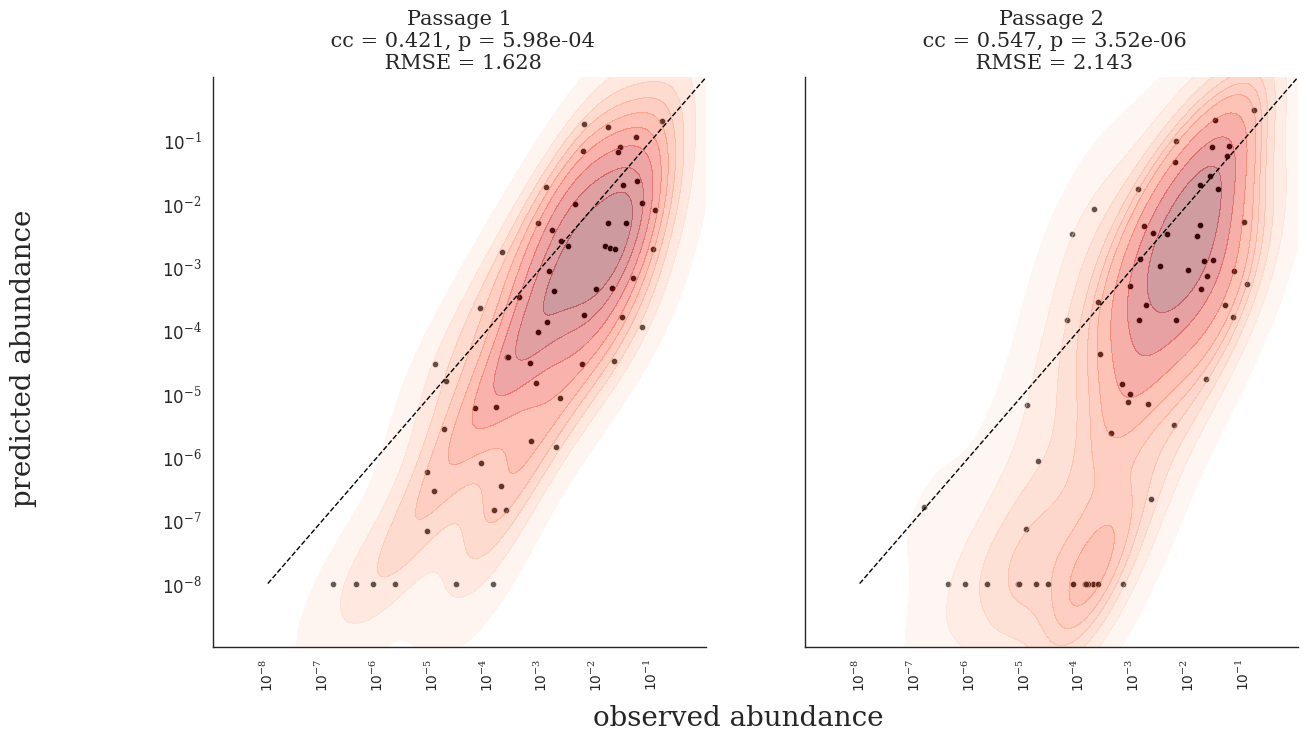

In [389]:
# Figure 2 for paper: prediction performance with production and iterative Balone

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(1, 2, figsize=(14, 7.4), sharey="row", sharex="col")
# axes = [axes_all]
fig.supylabel('predicted abundance', fontsize=20, x=-0.02, y=0.5)
fig.supxlabel('observed abundance', fontsize=20, x=0.5, y=-0.005)
df_pred_vs_obs = pd.DataFrame(data={'passage' : [], \
                                    'species' : [], \
                                    'predicted_abundance' : [], \
                                    'mean_observed_abundance' : [], \
                                    'min_observed_abundance' : [], \
                                    'max_observed_abundance' : []})
num_passages_test = 2
n_breps_test = 1
rep_num = 2
max_to_min_pass = [None] * num_passages_test
abun_pred_pass = [None] * num_passages_test
abun_linear_pred_pass = [None] * num_passages_test
abun_orig_pass = [None] * num_passages_test
abun_orig_pass_rep = [None] * num_passages_test
sd_orig_pass = [None] * num_passages_test
RMSE_pred = [None] * num_passages_test
y_pred = {}
x0 = df_speciesAbun.iloc[:, 6 * rep_num + 0].values.copy()
for pass_ in range(num_passages_test):
    ax_row_ = int(pass_ / num_passages_test)
    ax_col_ = int(pass_ % num_passages_test)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(n_breps_test)
    y = df_speciesAbun.iloc[:, 6 * rep_num + pass_ + 1].values.copy()

    x = np.log10(x0.copy())
    y = np.log10(y.copy())
    y_orig = y.copy()
    
    id_filter = np.where(x >= -3)[0]
    RMSE_tmp = np.sqrt(np.mean(np.power(y_orig[id_filter] - x[id_filter], 2)))
    print(f'RMSE high-mid abundance = {RMSE_tmp}')
    

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=20, ax=axes[ax_col_], c="black")

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.4, cmap="Reds", \
                    ax=axes[ax_col_])
    plt_.plot([-8, 0], [-8, 0], c="black", linewidth=1, ls="dashed")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y_orig)
    corr_val_pe_log = scipy.stats.pearsonr(x, y_orig)
    corr_val_sp = scipy.stats.spearmanr(x, y_orig)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y_orig - x, 2)))
    std_error = np.sqrt(np.std(np.power(y_orig - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y_orig, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    title_ = f'Passage {pass_ + 2}' + \
            f'\n cc = {np.round(corr_val_pe_log[0], 3)}, p = ' + \
                    '{:.2e}'.format(corr_val_pe_log[1]) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'
    title_ = f'Passage {pass_ + 1}' + \
            f'\n cc = {np.round(corr_val_pe[0], 3)}, p = ' + \
                    '{:.2e}'.format(corr_val_pe[1]) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_col_].set_title(title_, size=15)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        yticks_ = np.arange(-8, 0, step=1)
        ylabs_ = []
        for y_ in yticks_:
            ylabs_.append(fr"${10}^{{\mathregular{{{y_}}}}}$")
        plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=9)
    if ax_row_ == 0:
        xticks_ = np.arange(-8, 0, step=1)
        xlabs_ = []
        for x_ in xticks_:
            xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
#             plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
        plt_.set_xticks(xticks_, labels=xlabs_, fontsize=10)
        axes[ax_col_].tick_params(axis='x', rotation=90) 
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsiz
#         plt_.set_xticks(np.arange(-10, 1, step=2))
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=9)
    axes[ax_col_].set_xlim(-9, 0)
    axes[ax_col_].set_ylim(-9, 0)
        
    plt_ = sns.despine(right=True, top=True, ax=axes[ax_col_])

# BEGIN: to save figure to svg
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', "review1", \
                                        "fit2reps_pass1to2_pred1rep"))
date_ = "20240721"
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_review1_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_hierachClust' + \
                                         f'_nullModelRep1_predAbunAsPassage3_linCorr.svg'))
fig.savefig(file_save, \
                    dpi=300, transparent=False, facecolor="white")

In [457]:
Ri_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0].copy().reshape((-1, 1))
x0 = df_speciesMetab_cluster.values.copy() @ Ri_avg
x0 = x0.flatten()
x0 /= np.sum(x0)

In [459]:
x0.sum()

1.0000000000000002

row = 0, col = 0
RMSE high-mid abundance = 0.6435393964141589
row = 0, col = 1
RMSE high-mid abundance = 0.761602940693003


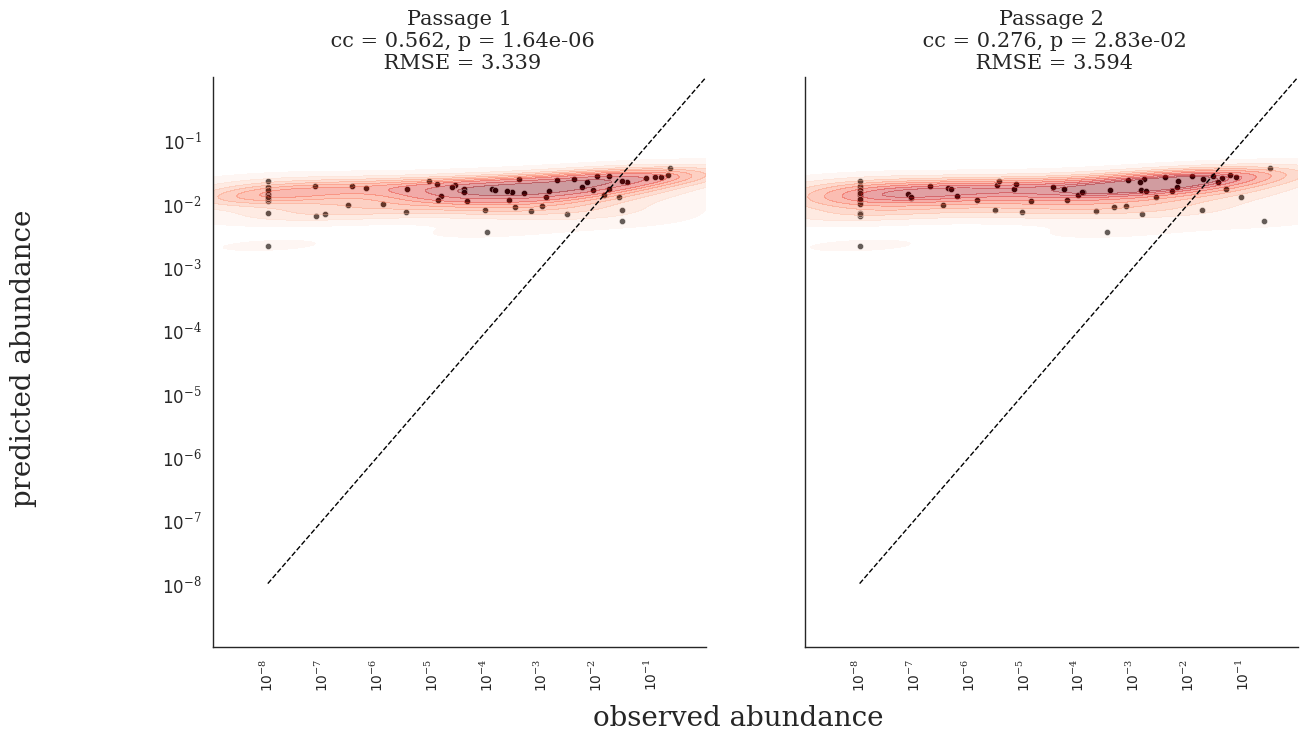

In [461]:
# Figure 2 for paper: prediction performance with production and iterative Balone

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(1, 2, figsize=(14, 7.4), sharey="row", sharex="col")
# axes = [axes_all]
fig.supylabel('predicted abundance', fontsize=20, x=-0.02, y=0.5)
fig.supxlabel('observed abundance', fontsize=20, x=0.5, y=-0.005)
df_pred_vs_obs = pd.DataFrame(data={'passage' : [], \
                                    'species' : [], \
                                    'predicted_abundance' : [], \
                                    'mean_observed_abundance' : [], \
                                    'min_observed_abundance' : [], \
                                    'max_observed_abundance' : []})
num_passages_test = 2
n_breps_test = 1
rep_num = 0
max_to_min_pass = [None] * num_passages_test
abun_pred_pass = [None] * num_passages_test
abun_linear_pred_pass = [None] * num_passages_test
abun_orig_pass = [None] * num_passages_test
abun_orig_pass_rep = [None] * num_passages_test
sd_orig_pass = [None] * num_passages_test
RMSE_pred = [None] * num_passages_test
y_pred = {}
x0 = df_speciesAbun.iloc[:, 6 * rep_num + 0].values.copy()
Ri_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0].copy().reshape((-1, 1))
x0 = df_speciesMetab_cluster.values.copy() @ Ri_avg
x0 = x0.flatten()
x0 /= np.sum(x0)
for pass_ in range(num_passages_test):
    ax_row_ = int(pass_ / num_passages_test)
    ax_col_ = int(pass_ % num_passages_test)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(n_breps_test)
    x = df_speciesAbun.iloc[:, 6 * rep_num + pass_ + 1].values.copy()

    x = np.log10(x.copy())
    y = np.log10(x0.copy())
    y_orig = y.copy()
    
    id_filter = np.where(x >= -3)[0]
    RMSE_tmp = np.sqrt(np.mean(np.power(y_orig[id_filter] - x[id_filter], 2)))
    print(f'RMSE high-mid abundance = {RMSE_tmp}')
    

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=20, ax=axes[ax_col_], c="black")

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.4, cmap="Reds", \
                    ax=axes[ax_col_])
    plt_.plot([-8, 0], [-8, 0], c="black", linewidth=1, ls="dashed")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y_orig)
    corr_val_pe_log = scipy.stats.pearsonr(x, y_orig)
    corr_val_sp = scipy.stats.spearmanr(x, y_orig)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y_orig - x, 2)))
    std_error = np.sqrt(np.std(np.power(y_orig - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y_orig, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    title_ = f'Passage {pass_ + 2}' + \
            f'\n cc = {np.round(corr_val_pe_log[0], 3)}, p = ' + \
                    '{:.2e}'.format(corr_val_pe_log[1]) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'
    title_ = f'Passage {pass_ + 1}' + \
            f'\n cc = {np.round(corr_val_pe[0], 3)}, p = ' + \
                    '{:.2e}'.format(corr_val_pe[1]) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_col_].set_title(title_, size=15)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        yticks_ = np.arange(-8, 0, step=1)
        ylabs_ = []
        for y_ in yticks_:
            ylabs_.append(fr"${10}^{{\mathregular{{{y_}}}}}$")
        plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=9)
    if ax_row_ == 0:
        xticks_ = np.arange(-8, 0, step=1)
        xlabs_ = []
        for x_ in xticks_:
            xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
#             plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
        plt_.set_xticks(xticks_, labels=xlabs_, fontsize=10)
        axes[ax_col_].tick_params(axis='x', rotation=90) 
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsiz
#         plt_.set_xticks(np.arange(-10, 1, step=2))
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=9)
    axes[ax_col_].set_xlim(-9, 0)
    axes[ax_col_].set_ylim(-9, 0)
        
    plt_ = sns.despine(right=True, top=True, ax=axes[ax_col_])

# BEGIN: to save figure to svg
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', "review1", \
                                        "fit2reps_pass1to2_pred1rep"))
date_ = "20240721"
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_review1_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_hierachClust' + \
                                         f'_nullModelRep1_predAbunAsPassage3_linCorr.svg'))
# fig.savefig(file_save, \
#                     dpi=300, transparent=False, facecolor="white")

PearsonRResult(statistic=0.6275842321466658, pvalue=3.7000640326084576e-08)


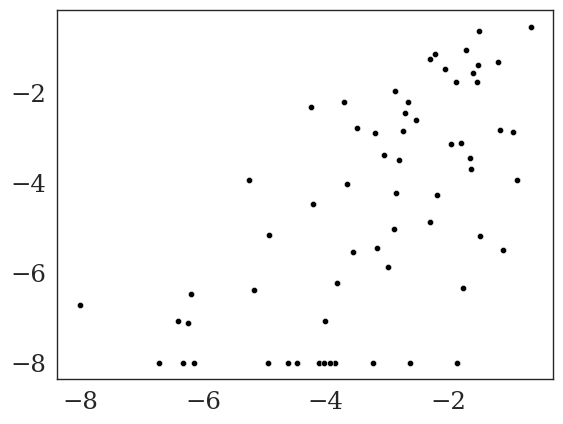

In [374]:
rep_num = 0
y = df_speciesAbun.iloc[:, 6 * rep_num + pass_ + 1].values.copy()
plt_ = sns.scatterplot(x=np.log10(x0), \
                        y=np.log10(y), s=20, c="black")
print(scipy.stats.pearsonr(np.log10(x0), np.log10(y)))

In [417]:
# compare Ri fit from different reps
# BEGIN: to save the data uncomment the following lines
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', "review1", \
                                        "fit2reps_pass1to2_pred1rep", "null_model_obsAbun"))
date_ = "20240721"

# train reps 1, 2
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_review1_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_hierachClust' + \
                                         f'_iterate_Nalone_fitReps12_pass1to2_predRep3.pickle'))
# load Ri_dynamic_obj from file
with open(file_save, "rb") as file_:
    Ri_dynamic_obj = pickle.load(file_)
# END: to save the data uncomment the following lines
r1_full = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0]
r1 = r1_full.copy()
r1[r1 <= 0] = 1e-12

# train reps 2, 3
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_review1_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_hierachClust' + \
                                         f'_iterate_Nalone_fitReps23_pass1to2_predRep1.pickle'))
# load Ri_dynamic_obj from file
with open(file_save, "rb") as file_:
    Ri_dynamic_obj = pickle.load(file_)
# END: to save the data uncomment the following lines
r2_full = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0]
r2 = r2_full.copy()
r2[r2 <= 0] = 1e-12

# train reps 3, 1
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_review1_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_hierachClust' + \
                                         f'_iterate_Nalone_fitReps31_pass1to2_predRep2.pickle'))
# load Ri_dynamic_obj from file
with open(file_save, "rb") as file_:
    Ri_dynamic_obj = pickle.load(file_)
# END: to save the data uncomment the following lines
r3_full = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0]
r3 = r3_full.copy()
r3[r3 <= 0] = 1e-12

In [413]:
print(np.min(r1[r1 != 0]))
print(np.min(r2[r2 != 0]))
print(np.min(r3[r3 != 0]))

1e-12
1e-12
1e-12


# Ri where r1 > 0 and r2 = 0: 8
# Ri where r1 = 0 and r2 > 0: 7
# Ri where r1 > 0 and r2 > 0: 30
# Ri where r1 = 0 and r2 = 0: 53
correlations for both non-zero or both zero
PearsonRResult(statistic=0.9987840070418891, pvalue=1.1684182645700261e-107)
PearsonRResult(statistic=0.9269372461896294, pvalue=3.1280932265189506e-36)
correlations for both non-zero only
PearsonRResult(statistic=0.9304648504330482, pvalue=9.855849157420779e-14)
PearsonRResult(statistic=0.9038663071259574, pvalue=7.768912175721234e-12)


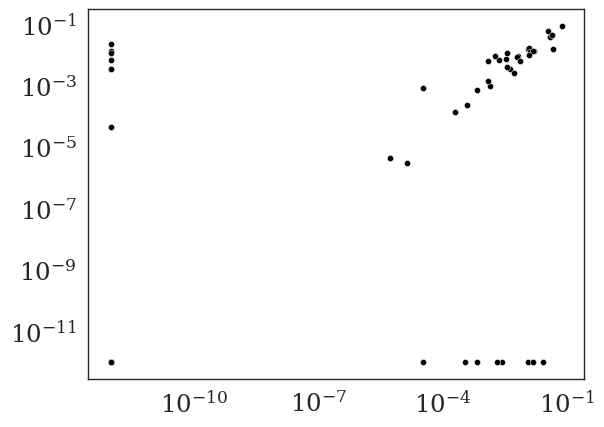

In [434]:
x = r1_full.copy()
y = r2_full.copy()
x_plt = r1.copy()
y_plt = r2.copy()

id_ = np.where((x > 0) & (y == 0))[0]
print(f'# Ri where r1 > 0 and r2 = 0: {len(id_)}')
id_ = np.where((x == 0) & (y > 0))[0]
print(f'# Ri where r1 = 0 and r2 > 0: {len(id_)}')
id_ = np.where((x > 0) & (y > 0))[0]
print(f'# Ri where r1 > 0 and r2 > 0: {len(id_)}')
id_ = np.where((x == 0) & (y == 0))[0]
print(f'# Ri where r1 = 0 and r2 = 0: {len(id_)}')
plt_ = sns.scatterplot(x=x_plt, y=y_plt, s=20, c="black")
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

id_ = np.where(((x > 0) & (y > 0)) | \
               ((x == 0) & (y == 0)))[0]
x1 = x[id_].copy()
y1 = y[id_].copy()
print(f'correlations for both non-zero or both zero')
print(scipy.stats.pearsonr(np.log10(x1 + 1e-12), np.log10(y1 + 1e-12)))
print(scipy.stats.pearsonr(x1, y1))

id_ = np.where(((x > 0) & (y > 0)))[0]
x1 = x[id_].copy()
y1 = y[id_].copy()
print(f'correlations for both non-zero only')
print(scipy.stats.pearsonr(np.log10(x1 + 1e-12), np.log10(y1 + 1e-12)))
print(scipy.stats.pearsonr(x1, y1))

Fig 2

row = 0, col = 0
RMSE high-mid abundance = 1.287880477093665
row = 0, col = 1
RMSE high-mid abundance = 0.8146392348066817
row = 0, col = 2
RMSE high-mid abundance = 1.3382403046894804


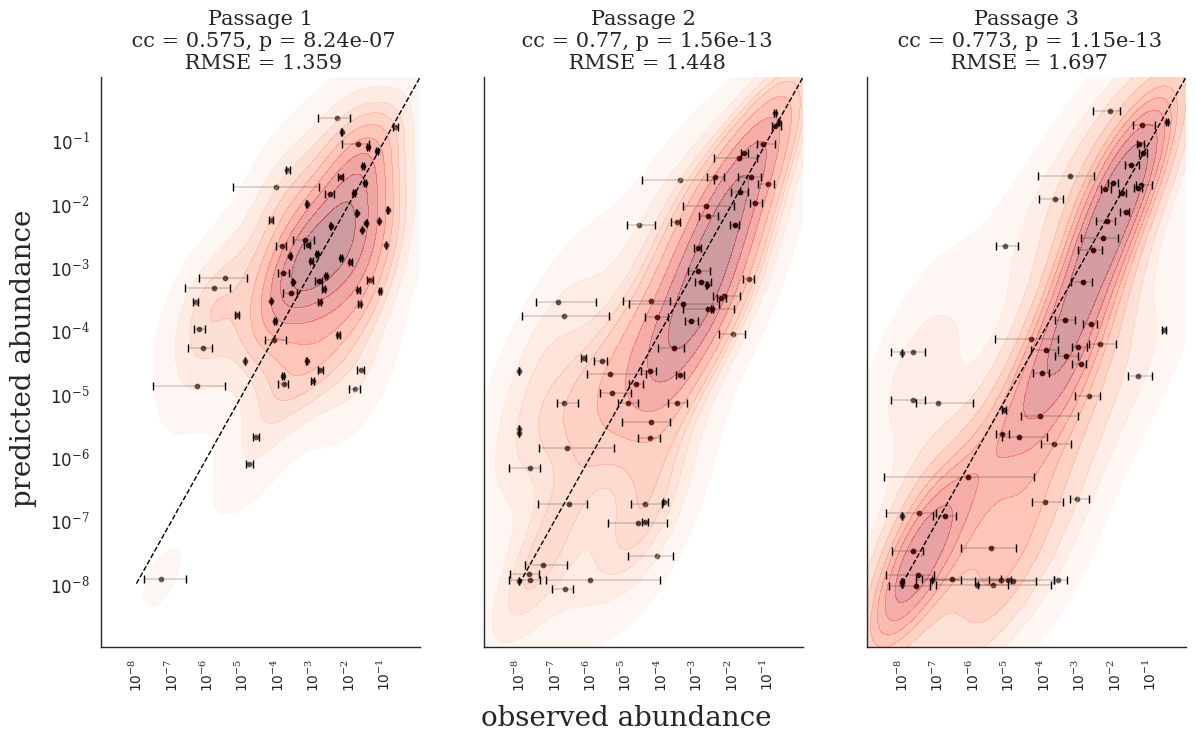

In [104]:
# Figure 2 for paper: prediction performance with production and iterative Balone

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(1, 3, figsize=(14, 7.4), sharey="row", sharex="col")
fig.supylabel('predicted abundance', fontsize=20, x=0.06, y=0.5)
fig.supxlabel('observed abundance', fontsize=20, x=0.5, y=-0.005)
df_pred_vs_obs = pd.DataFrame(data={'passage' : [], \
                                    'species' : [], \
                                    'predicted_abundance' : [], \
                                    'mean_observed_abundance' : [], \
                                    'min_observed_abundance' : [], \
                                    'max_observed_abundance' : []})
max_to_min_pass = [None] * 3
abun_pred_pass = [None] * 3
abun_linear_pred_pass = [None] * 3
abun_orig_pass = [None] * 3
abun_orig_pass_rep = [None] * 3
sd_orig_pass = [None] * 3
RMSE_pred = [None] * 3
for pass_ in range(3):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(3)
    x_f = sens_obj_all_prod[pass_]['df_speciesAbun_next_obs'].copy()
    x_f = x_f.flatten()
    y_f = sens_obj_all_prod[pass_]['df_speciesAbun_next_pred'].copy()
    thresh_zero = 1e-8
    y_f[y_f <= thresh_zero] = thresh_zero
    x_f[x_f <= thresh_zero] = thresh_zero

    x = np.zeros((num_species))
    x_min = np.zeros((num_species))
    x_max = np.zeros((num_species))
    y = np.zeros((num_species))
    sd_orig_pass[pass_] = np.zeros((num_species))
    RMSE_pred[pass_] = np.zeros((num_species))
    abun_linear_pred_pass[pass_] = np.zeros((num_species))
    abun_orig_pass_rep[pass_] = np.zeros((num_species, 3))
    for rep_ in range(3):
        id_ = np.arange(num_species) * 3 + rep_
        abun_orig_pass_rep[pass_][:, rep_] = np.log10(x_f[id_])
    for species_ in range(num_species):
        id_ = np.array([0, 1, 2]) + species_ * 3
        x[species_] = np.exp(np.mean(np.log(x_f[id_])))
        x_min[species_] = np.min(x_f[id_])
        x_max[species_] = np.max(x_f[id_])
        y[species_] = np.exp(np.mean(np.log(y_f[id_])))
        abun_linear_pred_pass[pass_][species_] = np.mean(x_f[id_])

        sd_orig_pass[pass_][species_] = np.sqrt(np.var((x_f[id_])))
        RMSE_pred[pass_][species_] = np.sqrt(np.mean(np.power(np.log10(x_f[id_]) - \
                                                    np.log10(y_f[id_]), 2)))
        
    x = np.log10(x)
    x_min = np.log10(x_min)
    x_max = np.log10(x_max)
    y = np.log10(y)
    y_orig = y.copy()
    
    id_filter = np.where(x >= -3)[0]
    RMSE_tmp = np.sqrt(np.mean(np.power(y_orig[id_filter] - x[id_filter], 2)))
    print(f'RMSE high-mid abundance = {RMSE_tmp}')
    
    id_ = np.where(y <= -7.99)[0]
    noise_ = np.random.choice([-4, -3, -2, -1, 0, 1, 2, 3, 4], len(id_), replace=True)
    y[id_] += noise_ / 50
    
    df_pred_vs_obs_tmp = pd.DataFrame(data={'passage' : [pass_] * len(x), \
                                      'species' : species_names[:].flatten(), \
                                      'predicted_abundance (log10)' : y, \
                                      'mean_observed_abundance (log10)' : x, \
                                      'min_observed_abundance (log10)' : x_min, \
                                      'max_observed_abundance (log10)' : x_max})
    max_to_min_pass[pass_] = x_max.copy() - x_min.copy()
    abun_pred_pass[pass_] = y_orig.copy()
    abun_orig_pass[pass_] = x.copy()
    if pass_ == 0:
        df_pred_vs_obs = df_pred_vs_obs_tmp.copy()
    else:
        df_pred_vs_obs = pd.concat((df_pred_vs_obs, df_pred_vs_obs_tmp), axis=0)
    
    def error_bar_(x):
        return (np.min(x), np.max(x))

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=20, ax=axes[ax_col_], c="black")
    xerr=np.vstack([x_max.flatten() - x.flatten(), \
                    x.flatten() - x_min.flatten()])
    xerr[xerr < 0] = 0
    axes[ax_col_].errorbar(x=x, y=y, yerr=None, \
                                    xerr=xerr, \
                                   fmt='none', elinewidth=0.2, c="black", \
                          capsize=3)

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.4, cmap="Reds", \
                    ax=axes[ax_col_])
    plt_.plot([-8, 0], [-8, 0], c="black", linewidth=1, ls="dashed")

    id_ = np.where(x >= -10)[0]
    corr_val_pe = scipy.stats.pearsonr(10**x[id_], 10**y_orig[id_])
    corr_val_pe_log = scipy.stats.pearsonr(x, y_orig)
    corr_val_sp = scipy.stats.spearmanr(x, y_orig)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y_orig - x, 2)))
    std_error = np.sqrt(np.std(np.power(y_orig - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y_orig, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    title_ = f'Passage {pass_ + 1}' + \
            f'\n cc = {np.round(corr_val_pe_log[0], 3)}, p = ' + \
                    '{:.2e}'.format(corr_val_pe_log[1]) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'
    # title_ = f'Passage {pass_ + 1}' + \
    #         f'\n cc = {np.round(corr_val_pe[0], 3)}, p = ' + \
    #                 '{:.2e}'.format(corr_val_pe[1]) + \
    #         f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_col_].set_title(title_, size=15)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        yticks_ = np.arange(-8, 0, step=1)
        ylabs_ = []
        for y_ in yticks_:
            ylabs_.append(fr"${10}^{{\mathregular{{{y_}}}}}$")
        plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=9)
    if ax_row_ == 0:
        xticks_ = np.arange(-8, 0, step=1)
        xlabs_ = []
        for x_ in xticks_:
            xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
#             plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
        plt_.set_xticks(xticks_, labels=xlabs_, fontsize=10)
        axes[ax_col_].tick_params(axis='x', rotation=90) 
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsiz
#         plt_.set_xticks(np.arange(-10, 1, step=2))
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=9)
    axes[ax_col_].set_xlim(-9, 0)
    axes[ax_col_].set_ylim(-9, 0)
        
    plt_ = sns.despine(right=True, top=True, ax=axes[ax_col_])

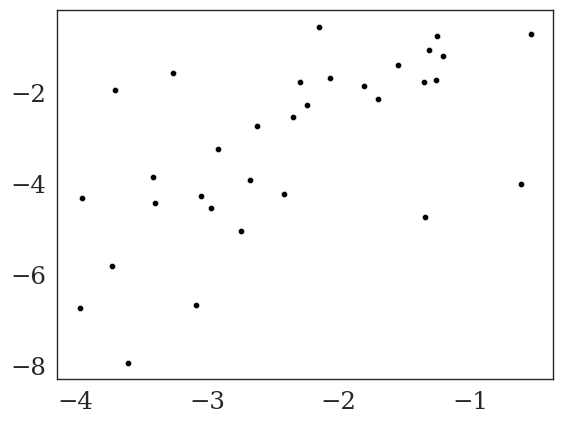

In [101]:
plt_ = sns.scatterplot(x=x[id_], \
                        y=y[id_], s=20, c="black")